### The hardest part is to consider at all aspects and details regarding pixels, data sizes, vocab_size, etc., and it is especially difficult to study the training process results (including intermediate) because GPT is a huge model and only one epoch takes about 1 hour with minimum dimensions parameters such as n_embd, n_layer, n_head.

### One of the peculiarities of setting and working with GPT is that image embeddings are built from floating point values, while the GPT model requires integer data to train.

### It is an interesting model to learn and discover for a variety of applications such as word processing, image processing, etc.

In [2]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
%matplotlib inline

In [4]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,)

In [5]:
!git clone https://github.com/karpathy/minGPT.git 

Cloning into 'minGPT'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (175/175), 1.37 MiB | 2.75 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [6]:
# IF KAGGLE
# move mingpt folder with utils in root kaggle directory for convinient work
!mv minGPT/mingpt /kaggle/working

In [ ]:
# IF GOOGLE COLAB
# move mingpt folder with utils in root colab directory for convinient work
!mv minGPT/mingpt /content

In [12]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [13]:
# pytorch helpfully makes it easy to download datasets, e.g. the common CIFAR-10 https://www.kaggle.com/c/cifar-10
root = './'
train_data = torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=True)
test_data  = torchvision.datasets.CIFAR10(root, train=False, transform=None, target_transform=None, download=True)
print(len(train_data), len(test_data))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
50000 10000


## Let's get embeddings of image using pretrained model

### Here define the pretrained model to get embeddings of images

In [23]:
# Load the pretrained model
model_resnet = models.resnet18(pretrained=True)
# Use the model object to select the desired layer
layer = model_resnet._modules.get('avgpool')

In [24]:
# Set model to evaluation mode
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# # Load the pretrained model with 1024 embedding size
# model_densenet = models.densenet121(pretrained=True)
# # Use the model object to select the desired layer
# # layer_densenet = model_densenet._modules.get('')
# layer_densenet = model_densenet.features.denseblock4.denselayer16.conv2
# model_densenet.eval()

In [16]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Define the function to extract embedding of an one image

In [25]:
def get_vector(image):
    # Create a PyTorch tensor with the transformed image
    t_img = transforms(image)
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)

    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())                 # <-- flatten

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    with torch.no_grad():                               # <-- no_grad context
        model_resnet(t_img.unsqueeze(0))                       # <-- unsqueeze
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding

# example
img, y = train_data[156]
img_embedding = get_vector(img)
print(len(img_embedding))

512


### Here embeddings shoud be transformed to integer data, because GPT model requires integer data to train. In reverse case, It doesn't work and error occurs.

In [26]:
from torch.utils.data import Dataset

class ImageEmbeddingsDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into embeddings
    """
    
    def __init__(self, dataset):
        self.dataset = dataset
        self.vocab_size = 512
        self.block_size = 32*32 - 1
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        x, y = self.dataset[index]
        img_embedding = get_vector(x)
        emb = img_embedding[:-1].clone().detach().long()

        return emb[:-1], emb[1:]  

train_dataset_own = ImageEmbeddingsDataset(train_data)
test_dataset_own = ImageEmbeddingsDataset(test_data)
print('Size of train dataset %s' % len(train_dataset_own))
print('Size of test dataset  %s' % len(test_dataset_own))

Size of train dataset 50000
Size of test dataset  10000


### Since the GPT is really huge, the parameters are reduced to small values so as not to grow old awaiting end of the training

In [27]:
from mingpt.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset_own.vocab_size, test_dataset_own.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=6, n_head=2, n_embd=128)
model = GPT(mconf)

### The number of epochs has been reduced to 5 for the above reason.

### Here are intermediate results of epochs for convinient review
epoch 1 iter 390: train loss 0.63072. lr 2.497556e-03: 100%|██████████| 391/391 [42:35<00:00,  6.54s/it]  
epoch 2 iter 390: train loss 0.54895. lr 4.995112e-03: 100%|██████████| 391/391 [42:34<00:00,  6.53s/it]  
epoch 3 iter 390: train loss 0.50229. lr 4.810799e-03: 100%|██████████| 391/391 [42:31<00:00,  6.53s/it]  
epoch 4 iter 390: train loss 0.49147. lr 4.270479e-03: 100%|██████████| 391/391 [42:58<00:00,  6.59s/it]  
epoch 5 iter 390: train loss 0.48308. lr 3.461140e-03: 100%|██████████| 391/391 [42:51<00:00,  6.58s/it]

In [28]:
from mingpt.trainer import Trainer, TrainerConfig

"""
Note that I am running on an 8-GPU V100 machine so each GPU has 32GB.
If you don't have as many computational resources you have to bring down
the batch_size until the model fits into your memory, and then you may
also need to adjust the learning rate (e.g. decrease it a bit). Alternatively,
you can use an even smaller model up above, bringing down the number of layers,
number of heads, and the embedding size.
"""

tokens_per_epoch = len(train_data) * train_dataset_own.block_size
train_epochs = 5 # todo run a bigger model and longer, this is tiny

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=128, learning_rate=5e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='cifar10_model.pt',
                      num_workers=8)
trainer = Trainer(model, train_dataset_own, test_dataset_own, tconf)
# trainer.train() # uncomment if it needs to train

In [ ]:
# load the state of the best model we've seen based on early stopping
checkpoint = torch.load('cifar10_model.pt')
model.load_state_dict(checkpoint)

In [29]:
# USE PREPARED FILE 5 EPOCHS
# IF KAGGLE
checkpoint_file = '/kaggle/input/checkpoint/cifar10_model_minGPT_5_epochs.pt' # OWN FILE
if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_file)
else:  
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
# USE PREPARED FILE 5 EPOCHS
# IF GOOGLE COLAB
checkpoint_file = 'cifar10_model_minGPT_5_epochs.pt' # OWN FILE
if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_file)
else:  
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

In [30]:
# to sample we also have to technically "train" a separate model for the first token in the sequence
# we are going to do so below simply by calculating and normalizing the histogram of the first token
counts = torch.ones(512) # start counts as 1 not zero, this is called "smoothing"
rp = torch.randperm(len(train_dataset_own))
nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset_own[int(rp[i])]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()
print(sum(prob).tolist())

1.000007152557373


In [32]:
# It should be normalized, because random.choice could cause error that probabilities do not sum to 1

new_prob = prob.tolist().copy()
new_prob = np.array(new_prob)
new_prob /= sum(prob)
print(sum(new_prob).tolist())

0.9999928574833732


In [40]:
# This cell could be produced zero or several times while sum(new_prob) do not be equal to 1 or if previous cell didn't print 1.0. 
# Sometime random.choice could execute even if sum(new_prob) is about 1.0, for example, 0.999999999658817
new_prob /= sum(new_prob)
print(sum(new_prob).tolist())

1.0


In [43]:
%%time

from mingpt.utils import sample

n_samples = 32
start_pixel = np.random.choice(np.arange(512), size=(n_samples, 1), replace=True, p=new_prob)
start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
pixels = sample(model, start_pixel, 32*32-1, temperature=15.0, sample=True, top_k=100)

CPU times: user 34.7 s, sys: 987 ms, total: 35.7 s
Wall time: 35.9 s


In [ ]:
print(np.shape(pixels))

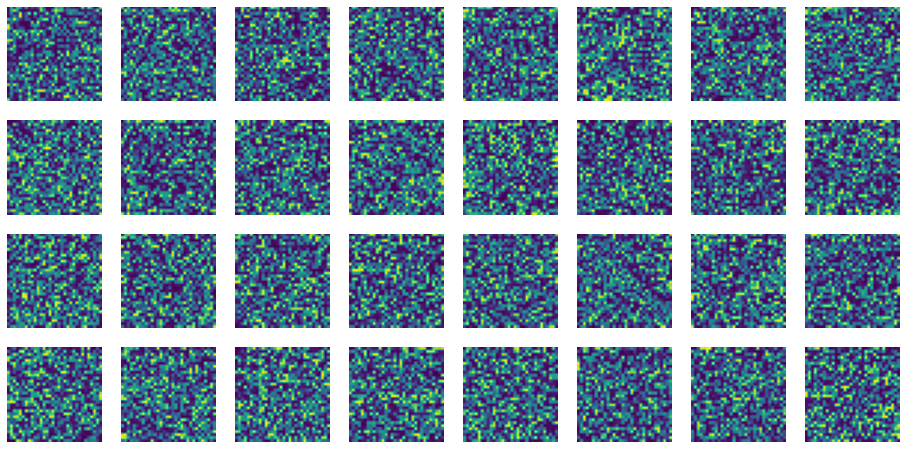

In [44]:
# try to visualize results
iperm = torch.argsort(torch.arange(32*32))

ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(16, 8))
for i in range(n_samples):
    pxi = pixels[i][:] 
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(pxi.cpu().view(32, 32).numpy().astype(np.uint8))
    plt.axis('off')

### "Half-image" pictures can be seen on the picture below. It just depends on the size of embeddings produced by pretrained model. And it's ok. It could be another model with output size 1024. So, we can explain such detail.

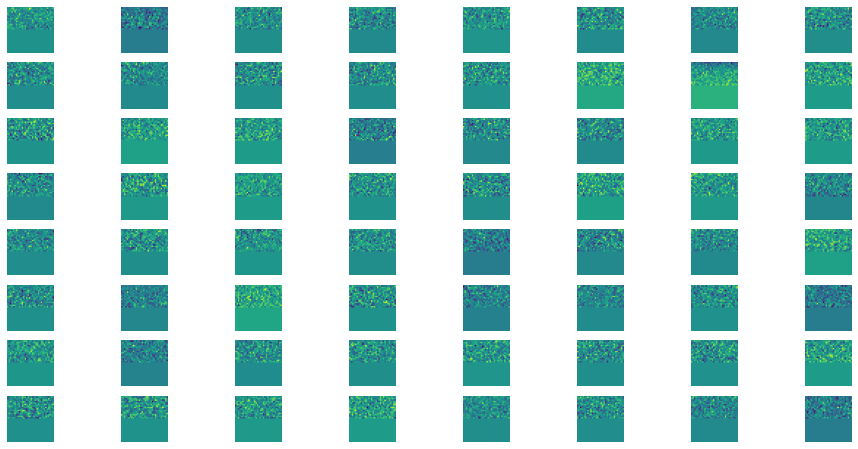

In [46]:
# visualize some of the learned positional embeddings, maybe they contain structure

# plt.figure(figsize=(5, 5))
plt.figure(figsize=(16, 8))
nsee = 8*8
ncol = 8
nrow = nsee // ncol
for i in range(nsee):
    
    ci = model.pos_emb.data[0, :, i].cpu()
    zci = torch.cat((torch.tensor([0.0]), ci)) # pre-cat a zero
    rzci = zci[iperm] # undo the permutation to recover the pixel space of the image
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(rzci.view(32, 32).numpy())
    plt.axis('off')